# **Deep Convolutional GANs**

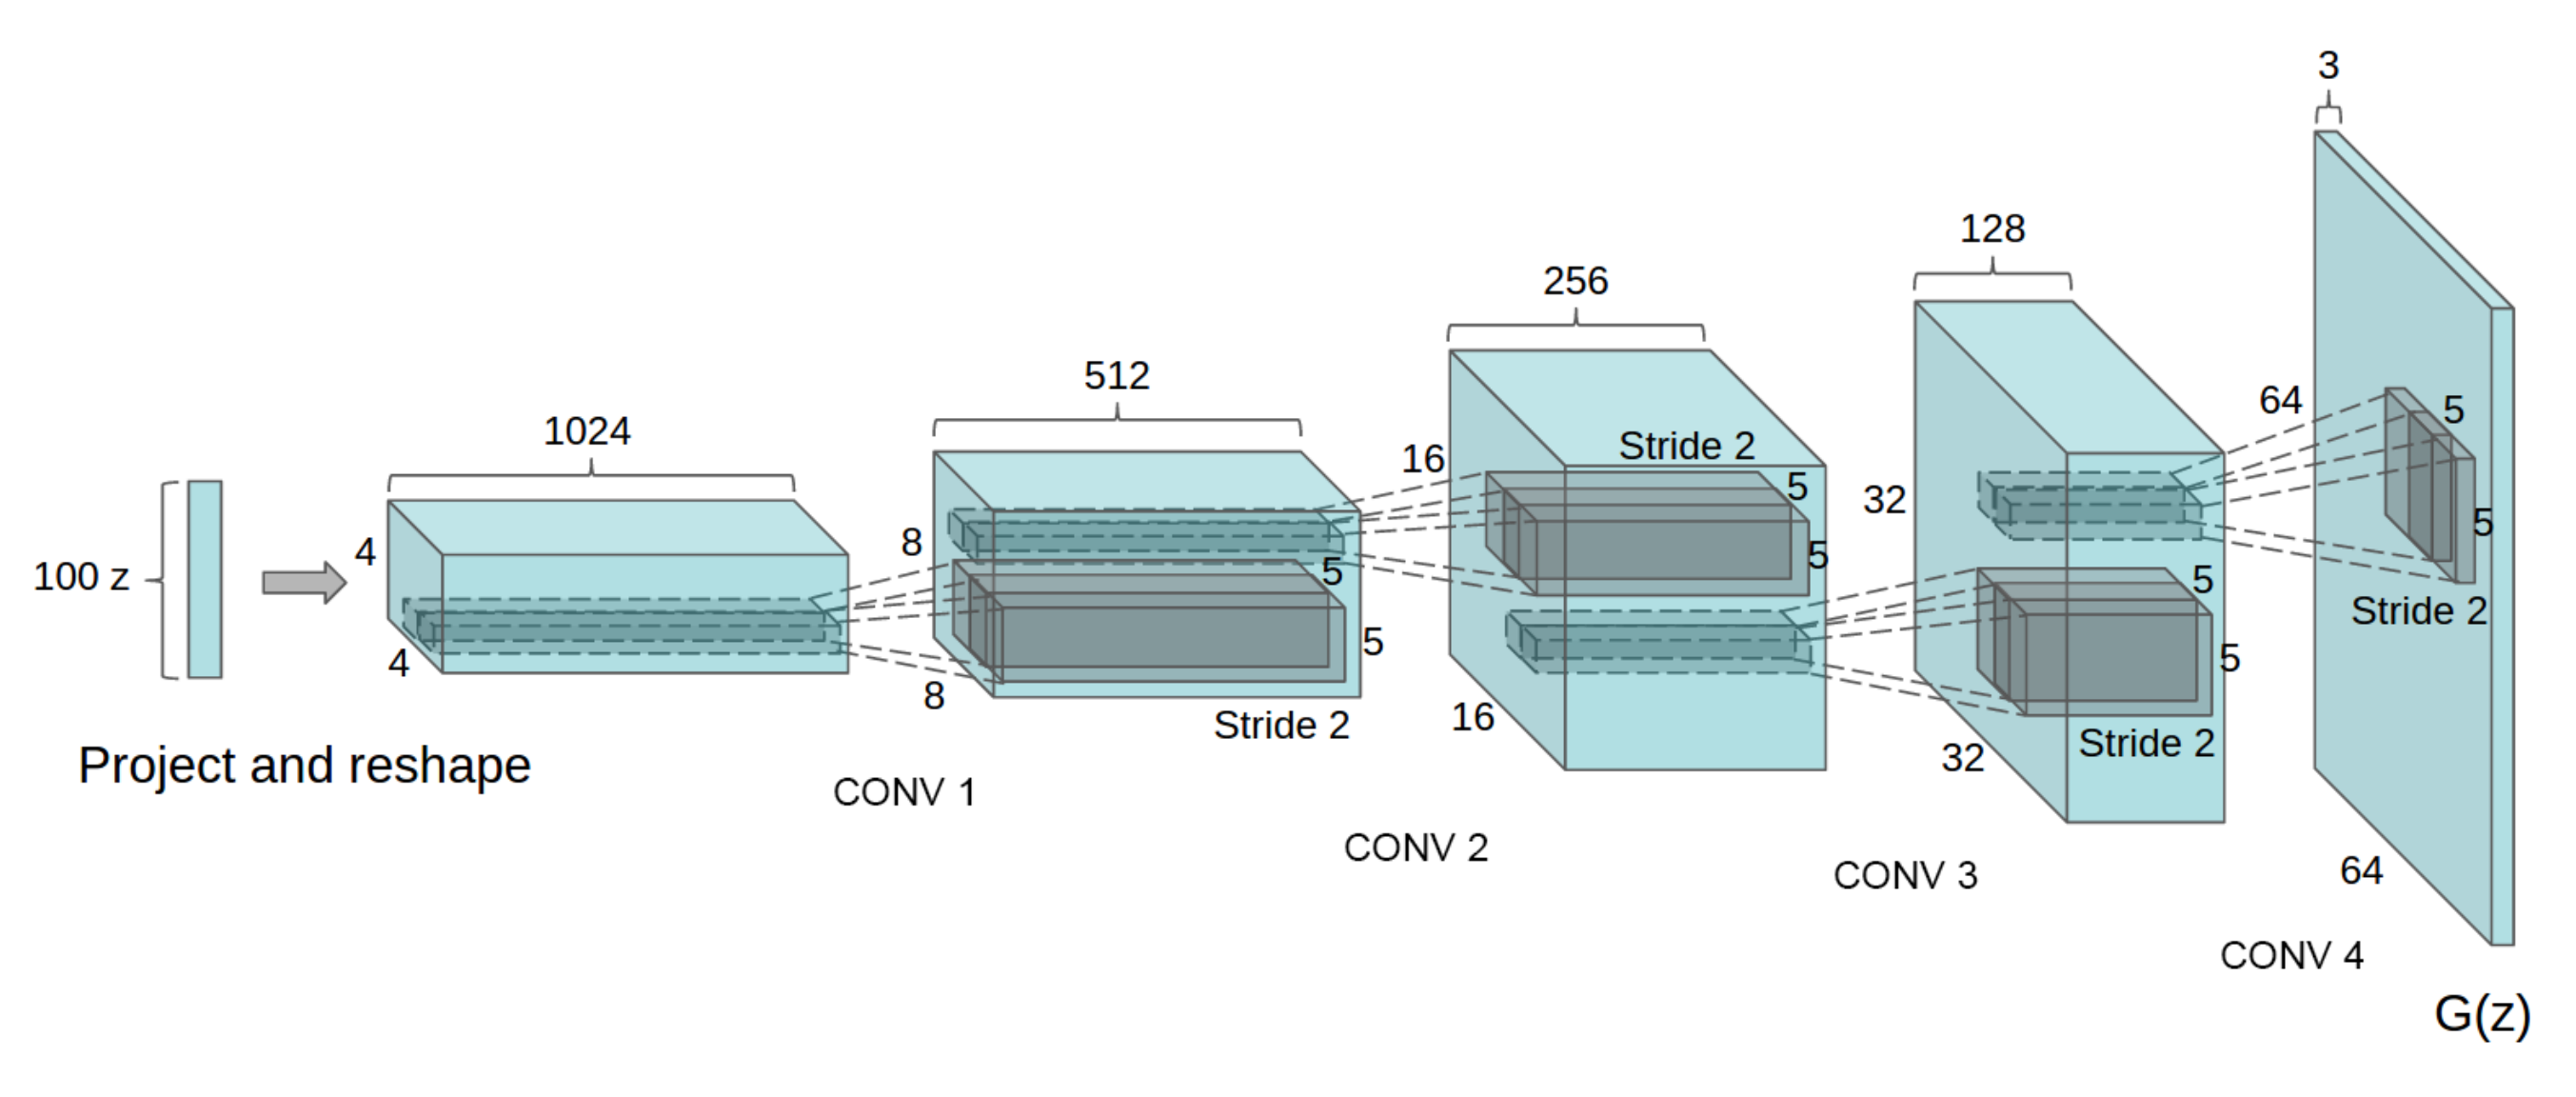

When it comes to **generative adversarial networks (GANs),** the advent of **deep convolutional GANs** marked **the onset of a transformative era** in the field of **generative modeling and data synthesis** using **neural networks**. This innovation significantly improved the **training process of GANs**, which had previously been **notoriously challenging** and **susceptible to drastic alterations** in model outcomes with **even minor adjustments**. Consequently, the development of an **optimal structure** for **deep convolutional GANs** became a **pivotal breakthrough**, albeit a **demanding endeavor.**

**Deep convolutional GANs, or DCGANs,** while not without their imperfections, represent a **substantial leap forward** in the **generative industry**. **DCGANs** are fundamentally rooted in **the core GAN concept** of pitting a **generator** against a **discriminator** in a **perpetual contest**. The generator strives to produce **increasingly realistic synthetic images**, while the discriminator endeavors to **distinguish between real and synthetic images**. Though this process may appear **straightforward**, it is **inherently intricate**, fraught with **challenges such as mode collapse**, the **forgetting problem**, and **various others**.

Nevertheless, **DCGANs exhibit greater stability compared to their predecessors.** The most **significant advancement** within **deep convolutional generative adversarial networks** is the **integration of convolutional neural networks**, hence the name **"deep convolutional."** Both the **generator and discriminator comprise convolutional layers**, enabling **more effective image mapping compared to the use of dense layers**, which exhibited suboptimal performance in this regard.

In summary, the advent of **deep convolutional GANs** has significantly improved the **landscape of generative modeling** by addressing **critical training issues and introducing convolutional network architecture,** **ultimately enhancing the overall quality and stability of generated data.**

# **Setting Up the Environment**

To create a **DCGAN**, we need to **import several essential libraries and functions** that are **instrumental in building the DCGAN**. In this section, **our primary focus** will be on **importing these critical components.**

In [1]:
# Model Building
import os
import torch
import numpy as np
from torch import nn

# Dataset
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

# Visualizations
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Set Random Seed
torch.manual_seed(42)

# Constants
Z_DIMS = 16
H_DIMS = 32
N_CHANNELS = 1               # We want to generate a black and white image.
DEVICE = "cuda"               # Make sure to enable gpu.
IMG_DIMS = 28                # Size of the image
LEARNING_RATE = 2e-4         # Learning rate of the Networks

# Additional optimizer parameters.
beta_1 = 0.5
beta_2 = 0.999

# **Generator Architecture**

At the **heart of the DCGAN**, we find the **generator architecture**. It **comprises a sequence of transposed convolutional layers** designed to take a **random noise vector** as **input and transform it into an image**.

The parameters related to this **noise vector include its dimension** and the **desired size of the output image**. These **parameters are independent**, with the **image size contingent on our end goal**, while the **noise vector's dimension impacts the generator's learning process**.

In essence, the **generator architecture** is a **model consisting of a series of consecutive transposed convolutional layers,** supplemented by **additional activation and batch normalization layers to enhance stability.**

In [3]:
class Generator(nn.Module):
    """
    Generator Class for a Deep Convolutional Generative Adversarial Network (DCGAN).

    Args:
        z_dim (int): Dimension of the input noise vector (default is Z_DIMS).
        hidden_dims (int): Dimension of the hidden layers (default is H_DIMS).
        image_channels (int): Number of channels in the output image (default is N_CHANNELS).

    Attributes:
        z_dim (int): Dimension of the input noise vector.
        gen (nn.Sequential): A sequence of layers defining the generator architecture.

    Methods:
        gen_block(in_dims, out_dims, kernel_size=4, stride=2, output_layer=False):
            Defines a generator block with convolution, batch normalization, and activation layers.
        forward(noise):
            Performs forward pass through the generator network.

    """

    def __init__(self, z_dim: int = Z_DIMS, hidden_dims: int = H_DIMS, image_channels: int = N_CHANNELS) -> None:
        """
        Initialize the Generator with provided input dimensions.

        Args:
            z_dim (int): Dimension of the input noise vector.
            hidden_dims (int): Dimension of the hidden layers.
            image_channels (int): Number of channels in the output image.
        """
        super(Generator, self).__init__()

        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dims * 4, kernel_size=3),
            self.gen_block(hidden_dims * 4, hidden_dims * 2, stride=1),
            self.gen_block(hidden_dims * 2, hidden_dims, kernel_size=3),
            self.gen_block(hidden_dims, image_channels, output_layer=True)
        )

    def gen_block(self, in_dims: int, out_dims: int, kernel_size: int = 4, stride: int = 2, output_layer: bool = False):
        """
        Define a generator block with convolution, batch normalization, and activation layers.

        Args:
            in_dims (int): Number of input channels.
            out_dims (int): Number of output channels.
            kernel_size (int): Size of the convolutional kernel (default is 4).
            stride (int): Stride for convolution (default is 2).
            output_layer (bool): Whether it's the final output layer (default is False).

        Returns:
            nn.Sequential: A sequence of convolutional layers with appropriate activation functions.

        """
        if not output_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_dims, out_dims, kernel_size, stride),
                nn.BatchNorm2d(out_dims),
                nn.LeakyReLU()
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_dims, out_dims, kernel_size, stride),
                nn.Tanh()
            )

    def forward(self, noise):
        """
        Perform a forward pass through the generator network.

        Args:
            noise (torch.Tensor): Input noise tensor to generate images.

        Returns:
            torch.Tensor: Generated images.
        """
        noise = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(noise)


This serves as the **foundation of our generator**. We will utilize this component to construct the **generator network** later in the notebook when we delve into the **comprehensive model architecture**.

However, currently, we are **missing one crucial function.** While our generator processes **noise**, we have yet to **create a function** for **generating this noise**. Let's address that now.

In [4]:
def generate_noise(samples: int, z_dim: int = Z_DIMS, device=DEVICE):
    """
    Generate random noise for input to the generator.

    Args:
        samples (int): Number of noise samples to generate.
        z_dim (int): Dimension of the noise vector (default is Z_DIMS).
        device: The device to place the generated noise tensor (default is DEVICE).

    Returns:
        torch.Tensor: Random noise tensor of shape (samples, z_dim).
    """
    return torch.randn(samples, z_dim, device=device)


Let's visually examine the **appearance of the generated noise**. This will help us appreciate the **challenge of creating meaningful content from a seemingly random and chaotic source**, as we aim to **synthesize an image of an object from this noise.**

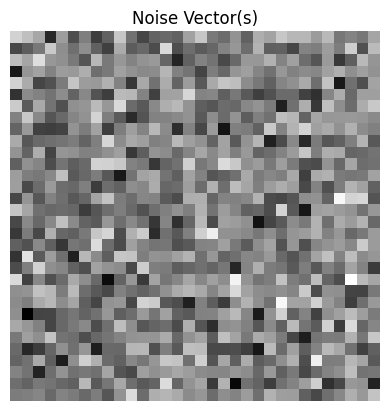

In [5]:
# Generating a noise of 32 by 32 pixels.
noise = generate_noise(32, z_dim=32, device="cpu")

# Visual the Noise Vector
plt.title("Noise Vector(s)")
plt.imshow(noise, cmap='gray')
plt.axis('off')
plt.show()

I'd like to clarify that when we refer to the **'noise vector,'** we are not feeding the entire **noise vector** into the **generator network**.

Instead, we are working with a **slice or a single row** of the **noise vector**, which corresponds to **generating an image**. In this context, the **'32' on the first axis** and **'z_dim' on the second axis** represent the **number of samples and the dimensions of the noise vector, respectively.**

---

For the time being, let's proceed to **create a generator** and observe the **image generation capabilities** of this **untrained generator.**

In [6]:
# Initialize the generator
base_gen = Generator()

# Generate noise vector
noise = generate_noise(10, device='cpu')

# Model generated images from noise vector
synthetic_images = base_gen(noise)

In [7]:

def show_generations(generations, n_rows, n_cols, figsize=(8, 5), title=None, save_loc=None):
    """
    Display a grid of synthetic images generated by the generator.

    Args:
        generations (torch.Tensor): A tensor containing synthetic image data.
        n_rows (int): Number of rows in the grid.
        n_cols (int): Number of columns in the grid.
        figsize (tuple): Size of the figure (default is (8, 5)).
        title (str): Title for the figure (default is None).
        save_loc (str): File path to save the figure (default is None).

    """
    synthetic_images = generations.view(-1, IMG_DIMS, IMG_DIMS, N_CHANNELS).detach().cpu()

    plt.figure(figsize=figsize)
    plt.suptitle("Synthetic Images" if title is None else title)

    for index in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(synthetic_images[index], cmap='gray')
        plt.axis('off')

    if save_loc is not None:
        if not os.path.exists(os.path.dirname(save_loc)):
            os.makedirs(os.path.dirname(save_loc))
        plt.savefig(save_loc)

    plt.show()


It's beneficial that we've established this function. It will prove to be valuable in the later stages when we proceed with training the generative adversarial network.

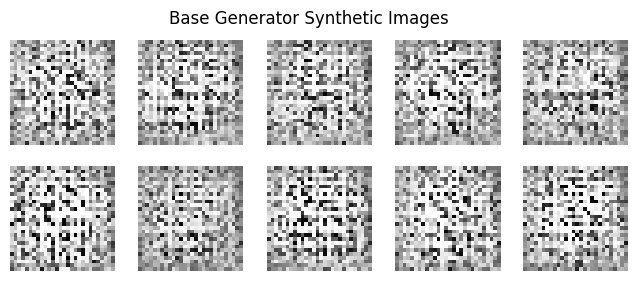

In [8]:
show_generations(
    synthetic_images, 2, 5,
    figsize=(8, 3),
    title="Base Generator Synthetic Images",
    save_loc="./Images/base_generations.png"
)

At the moment, it's evident that the **model's generated images are not of high quality**. They appear more like **random noise patterns** rather than **meaningful objects or structures**.

# **Discriminator Architecture**

The **discriminator network** bears **resemblance to a classifier network** used for **binary classification** tasks in **machine learning**. It comprises a **sequence of successive convolutional layers designed to downsample the input images**, which can be either **generated by the model or real images**. The aim is to reduce these images to a single vector that effectively determines their authenticity, labeling them as either **real (1) or fake (0).** This essentially transforms the problem into a **binary classification task**.

However, it's crucial to note that, because **classifying real or fake images** is a **relatively simpler** task compared to the intricate **task of image generation**, this architecture has a **significant influence** on the **information shared** with the **generator network**. Due to the **relative ease** of the **classification task**, the **training phase** of the **GAN** still encounters **numerous challenges**.

In [9]:

class Discriminator(nn.Module):
    """
    Discriminator Class for a Deep Convolutional Generative Adversarial Network (DCGAN).

    Args:
        image_channels (int): Number of channels in the input images (default is N_CHANNELS).
        hidden_dims (int): Dimension of the hidden layers (default is 16).

    Attributes:
        disc (nn.Sequential): A sequence of layers defining the discriminator architecture.

    Methods:
        disc_block(in_dims, out_dims, kernel_size=3, strides=2, output_layer=False):
            Defines a discriminator block with convolution, batch normalization, and activation layers.
        forward(images):
            Performs forward pass through the discriminator network.

    """

    def __init__(self, image_channels: int = N_CHANNELS, hidden_dims: int = 16):
        """
        Initialize the Discriminator with provided input dimensions.

        Args:
            image_channels (int): Number of channels in the input images.
            hidden_dims (int): Dimension of the hidden layers.
        """
        super(Discriminator, self).__init__()

        self.disc = nn.Sequential(
            self.disc_block(image_channels, hidden_dims),
            self.disc_block(hidden_dims, hidden_dims * 2),
            self.disc_block(hidden_dims * 2, 1, output_layer=True),
        )

    def disc_block(self, in_dims: int, out_dims: int, kernel_size: int = 4, strides: int = 2, output_layer: bool = False):
        """
        Define a discriminator block with convolution, batch normalization, and activation layers.

        Args:
            in_dims (int): Number of input channels.
            out_dims (int): Number of output channels.
            kernel_size (int): Size of the convolutional kernel (default is 3).
            strides (int): Stride for convolution (default is 2).
            output_layer (bool): Whether it's the final output layer (default is False).

        Returns:
            nn.Sequential: A sequence of convolutional layers with appropriate activation functions.

        """
        if not output_layer:
            return nn.Sequential(
                nn.Conv2d(in_dims, out_dims, kernel_size, strides),
                nn.BatchNorm2d(out_dims),
                nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_dims, out_dims, kernel_size, strides)
            )

    def forward(self, images):
        """
        Perform a forward pass through the discriminator network.

        Args:
            images (torch.Tensor): Input image tensor to classify.

        Returns:
            torch.Tensor: Classification output (real or fake).
        """
        return self.disc(images).view(len(images), -1)


Testing the **untrained discriminator network** at this point **wouldn't yield meaningful results**. Its responses are **more likely** to be **random rather than providing meaningful assessments**, given that it has yet to **undergo training.**

# **DC GAN Network**

Having successfully built the **individual components**, including the **generator and discriminator networks,** which form the **foundation of the Generative Adversarial Network**, we can now proceed to construct the complete **DCGAN**.

---
Note : Please connect to a **GPU device**, if using **CPU** please set the **DEVICE** constant to **"cpu"**.

In [10]:
# Initialize the generator and discriminator.
generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

# Initialize the optimizers, respectively.
gen_opt = torch.optim.Adam(generator.parameters(), lr = LEARNING_RATE, betas=(beta_1, beta_2))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr = LEARNING_RATE, betas=(beta_1, beta_2))

In [11]:
# Initializing the weights, so that they belong to a normal distribution.
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

generator = generator.apply(weights_init)
discriminator = discriminator.apply(weights_init)

Having prepared **the generator and the discriminator blocks** with their **initialized weights**, it's now time to **tackle some critical tasks**. Firstly, we need to establish **the criteria** that will guide **our training process**. Additionally, we haven't **loaded the dataset yet**, so we'll also **address the data loading step**.

In [12]:
BATCH_SIZE = 8                                      # Batch size also affected the training process.
criterion = nn.BCEWithLogitsLoss()                  # You might prefer to call it "loss function".

In [13]:
# Initialize the transformations.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Initialize the data loader.
dataloader = DataLoader(
    MNIST('.', download = True, transform = transform),
    batch_size = BATCH_SIZE,
    shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 230342731.07it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 117493398.47it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 68754636.70it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22625331.08it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Finally, we can proceed to create the training loop.

# **GAN Training Process**

  0%|          | 0/7500 [00:00<?, ?it/s]

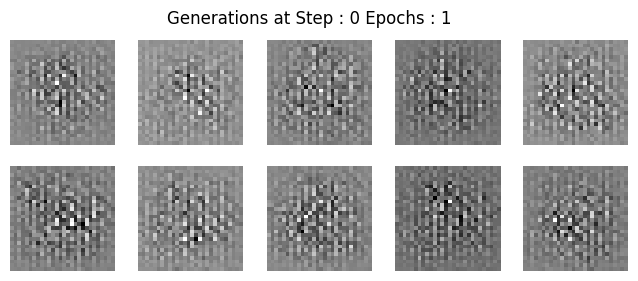

 13%|█▎        | 996/7500 [00:19<03:03, 35.50it/s]

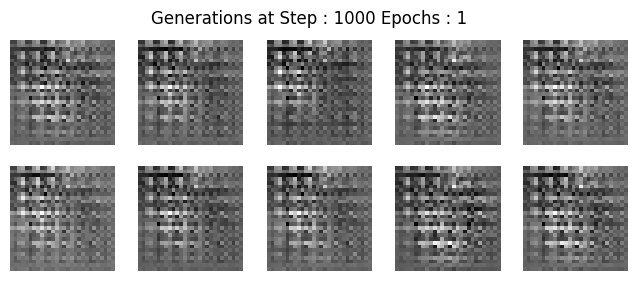

 27%|██▋       | 1989/7500 [00:29<00:48, 112.94it/s]

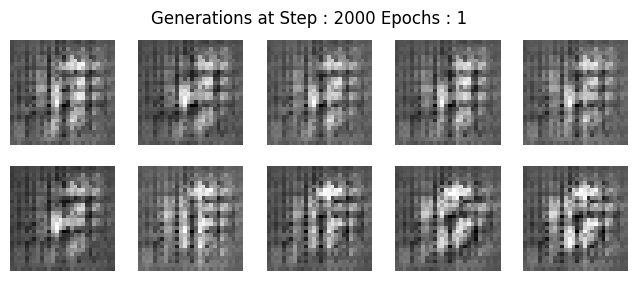

 40%|███▉      | 2995/7500 [00:39<00:41, 108.76it/s]

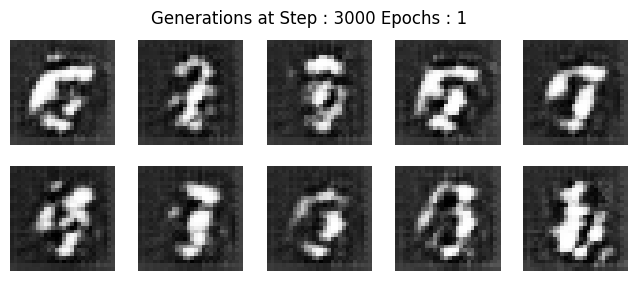

 53%|█████▎    | 3994/7500 [00:49<00:30, 116.65it/s]

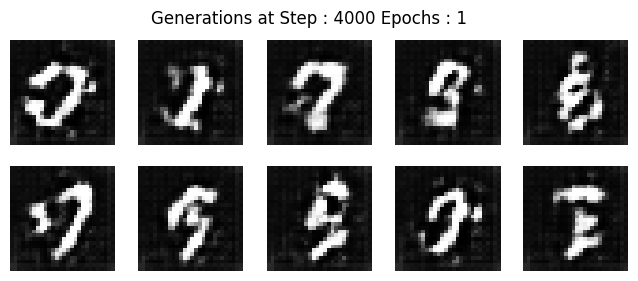

 67%|██████▋   | 4990/7500 [00:59<00:22, 110.87it/s]

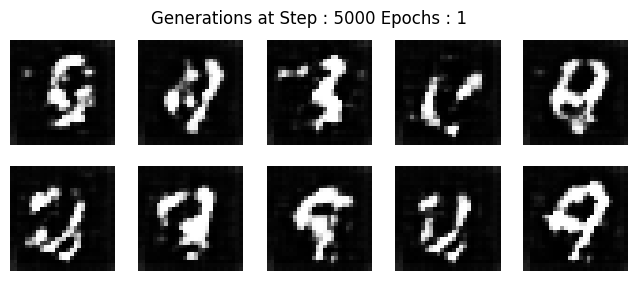

 80%|███████▉  | 5997/7500 [01:08<00:16, 88.89it/s]

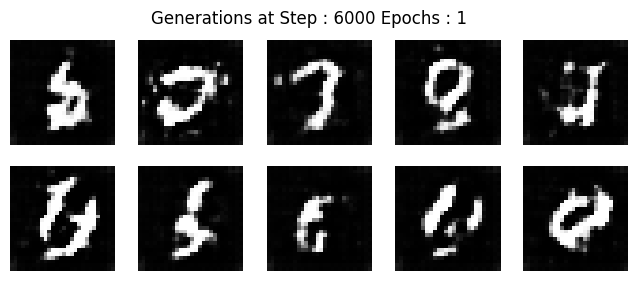

 93%|█████████▎| 6999/7500 [01:18<00:04, 112.63it/s]

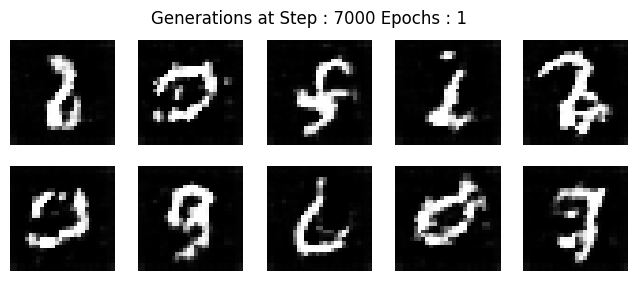

  0%|          | 0/7500 [00:00<?, ?it/s]

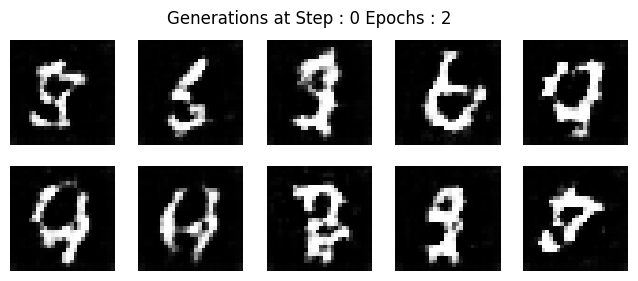

 13%|█▎        | 995/7500 [00:09<01:18, 82.45it/s]

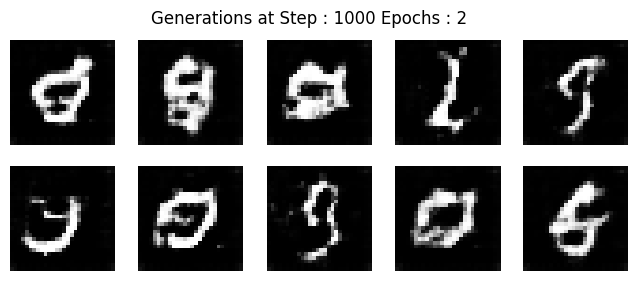

 27%|██▋       | 2000/7500 [00:19<00:52, 104.16it/s]

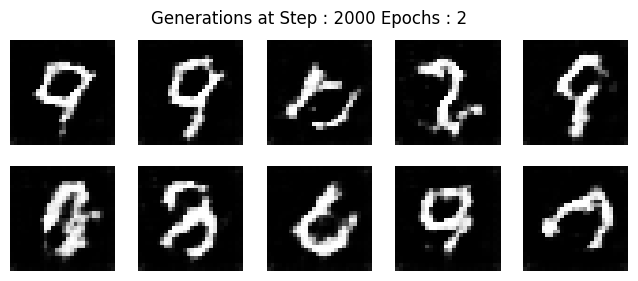

 40%|███▉      | 2995/7500 [00:29<00:41, 109.49it/s]

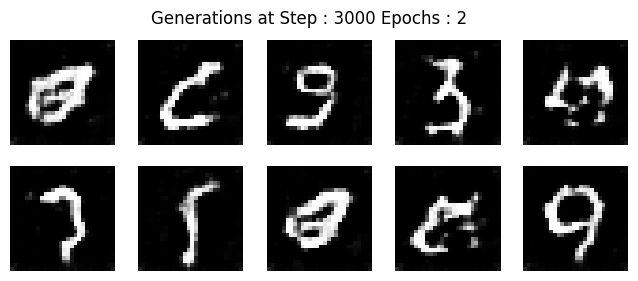

 53%|█████▎    | 4000/7500 [00:40<00:31, 112.29it/s]

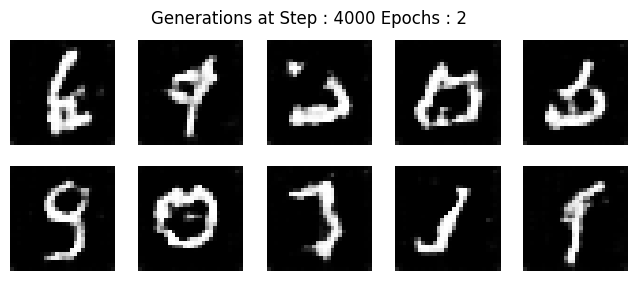

 67%|██████▋   | 4991/7500 [00:51<00:23, 107.39it/s]

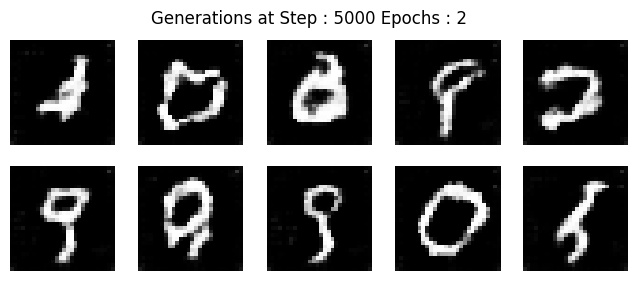

 80%|████████  | 6000/7500 [01:01<00:13, 107.50it/s]

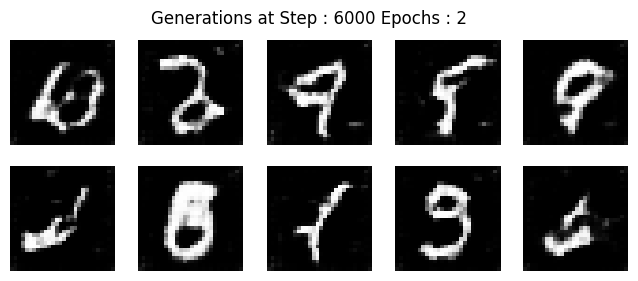

 93%|█████████▎| 6996/7500 [01:11<00:06, 79.04it/s]

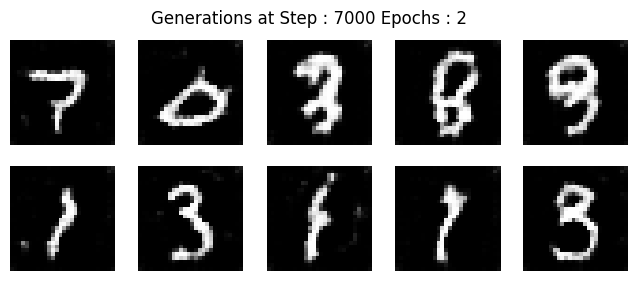

  0%|          | 0/7500 [00:00<?, ?it/s]

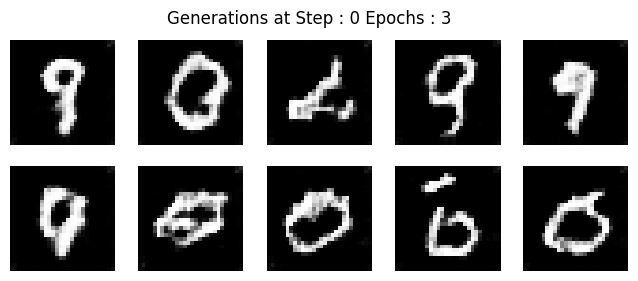

 13%|█▎        | 996/7500 [00:10<01:00, 108.10it/s]

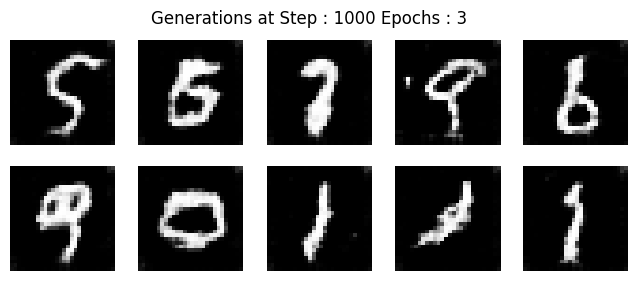

 27%|██▋       | 1991/7500 [00:21<00:54, 100.85it/s]

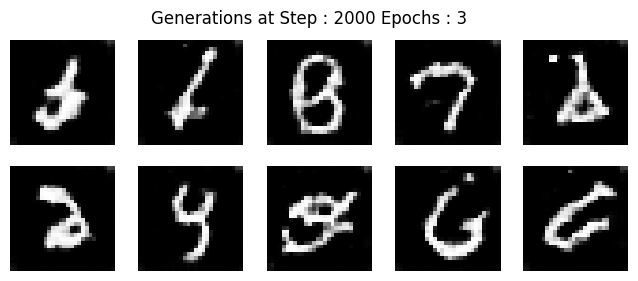

 40%|███▉      | 2999/7500 [00:31<00:58, 77.17it/s]

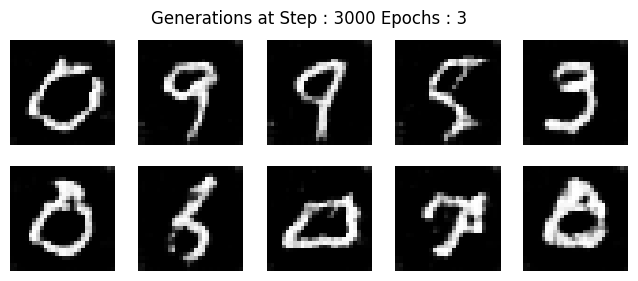

 53%|█████▎    | 3999/7500 [00:41<00:32, 107.88it/s]

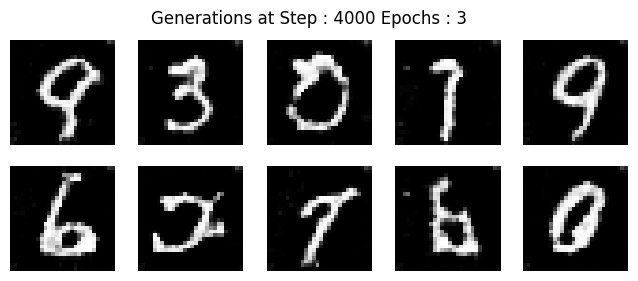

 67%|██████▋   | 4995/7500 [00:51<00:23, 105.69it/s]

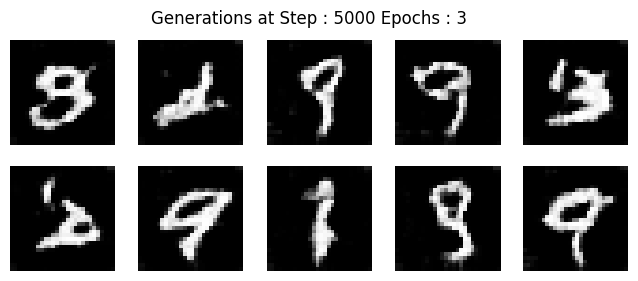

 80%|███████▉  | 5990/7500 [01:02<00:14, 106.16it/s]

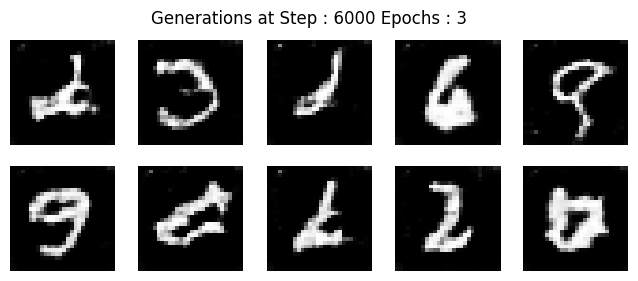

 93%|█████████▎| 7000/7500 [01:13<00:04, 110.73it/s]

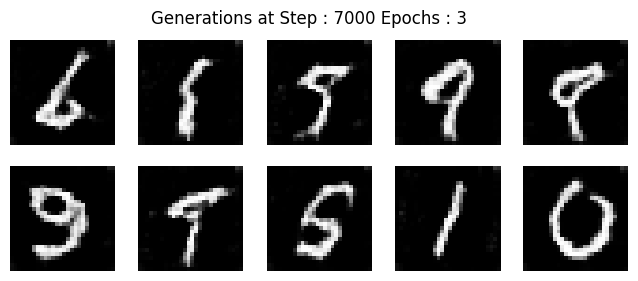

  0%|          | 0/7500 [00:00<?, ?it/s]

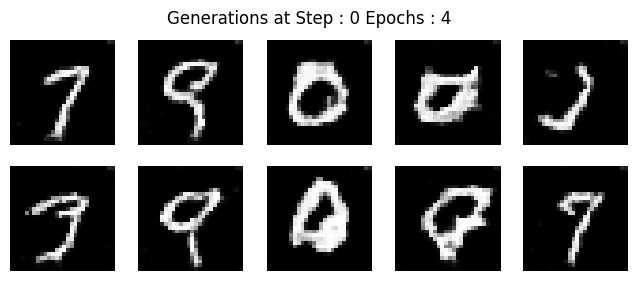

 13%|█▎        | 993/7500 [00:10<01:02, 104.23it/s]

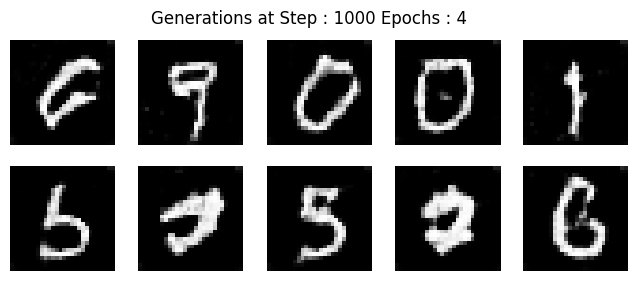

 27%|██▋       | 2000/7500 [00:21<00:50, 109.61it/s]

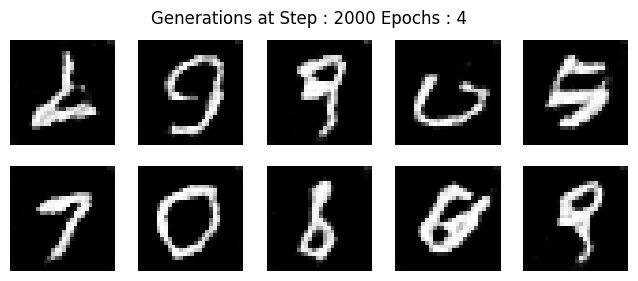

 40%|███▉      | 2997/7500 [00:31<00:43, 104.41it/s]

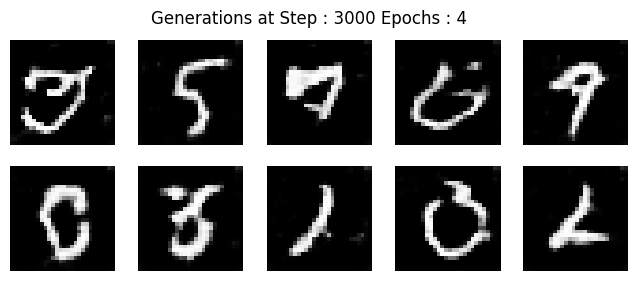

 53%|█████▎    | 3997/7500 [00:41<00:32, 106.82it/s]

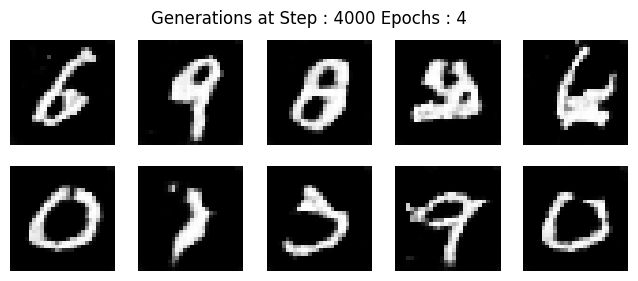

 67%|██████▋   | 4993/7500 [00:52<00:31, 79.01it/s]

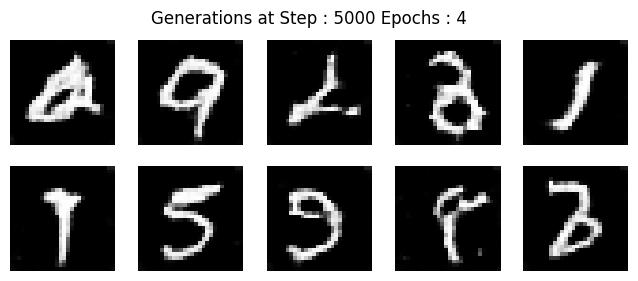

 80%|███████▉  | 5997/7500 [01:01<00:14, 106.92it/s]

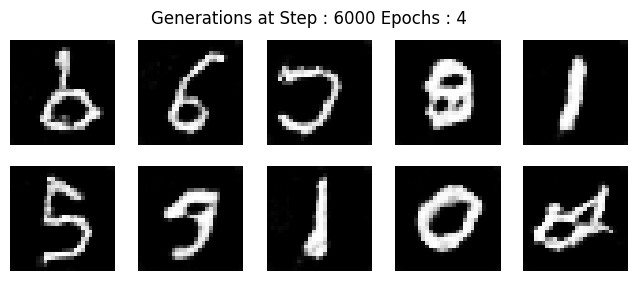

 93%|█████████▎| 6992/7500 [01:12<00:04, 104.05it/s]

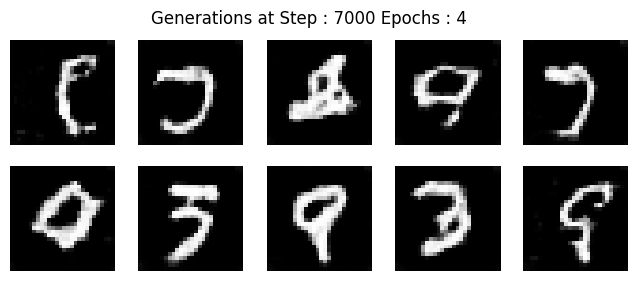

  0%|          | 0/7500 [00:00<?, ?it/s]

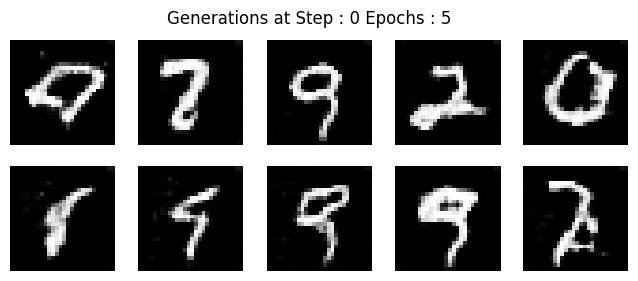

 13%|█▎        | 999/7500 [00:10<01:22, 78.76it/s]

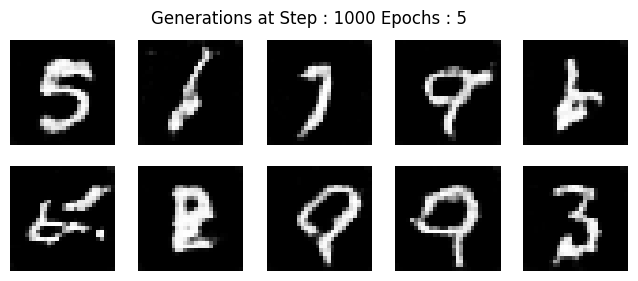

 27%|██▋       | 1995/7500 [00:20<00:52, 104.56it/s]

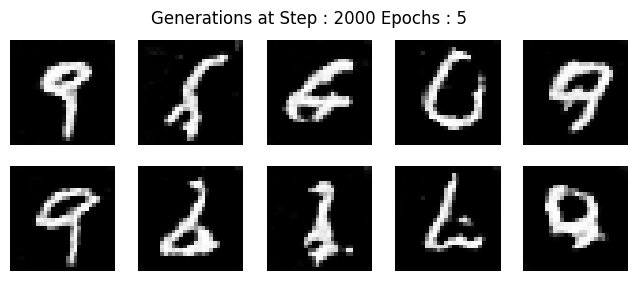

 40%|███▉      | 2996/7500 [00:30<00:41, 107.76it/s]

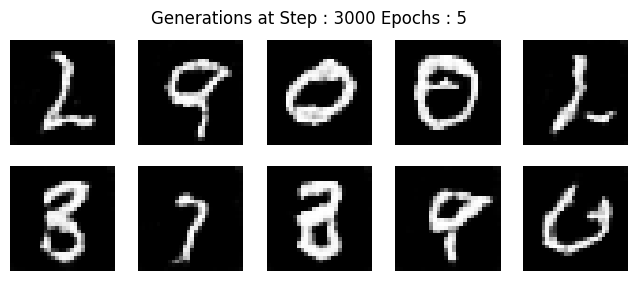

 53%|█████▎    | 4000/7500 [00:41<00:33, 106.01it/s]

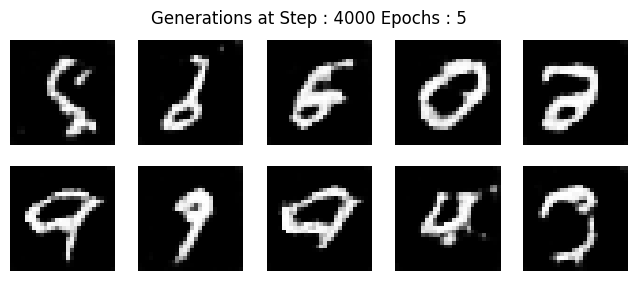

 67%|██████▋   | 4994/7500 [00:51<00:23, 105.87it/s]

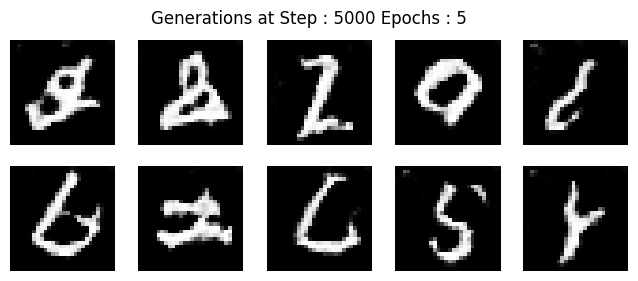

 80%|████████  | 6000/7500 [01:02<00:14, 104.18it/s]

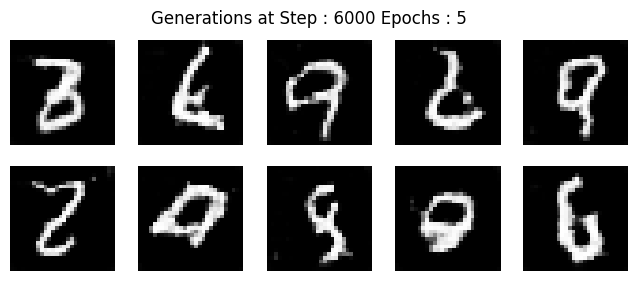

 93%|█████████▎| 6996/7500 [01:12<00:06, 81.90it/s]

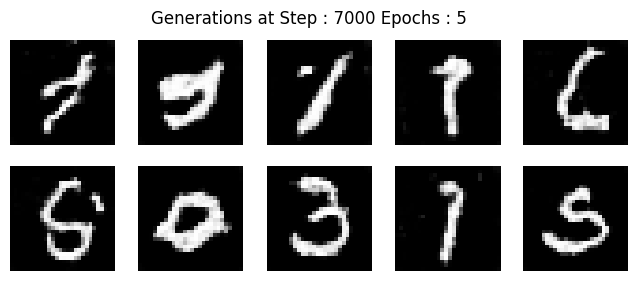

  0%|          | 0/7500 [00:00<?, ?it/s]

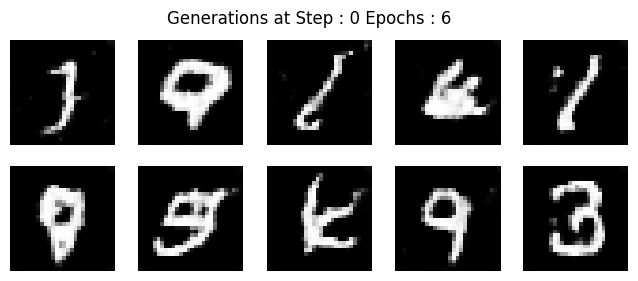

 13%|█▎        | 990/7500 [00:10<00:59, 109.56it/s]

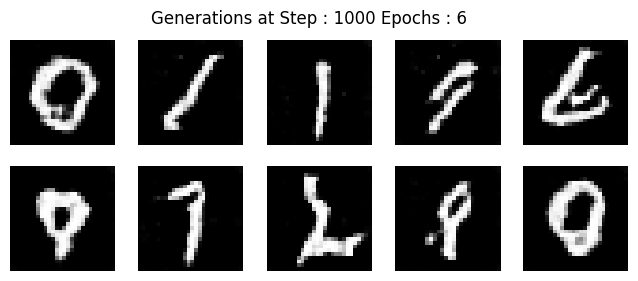

 27%|██▋       | 1993/7500 [00:20<00:55, 99.99it/s]

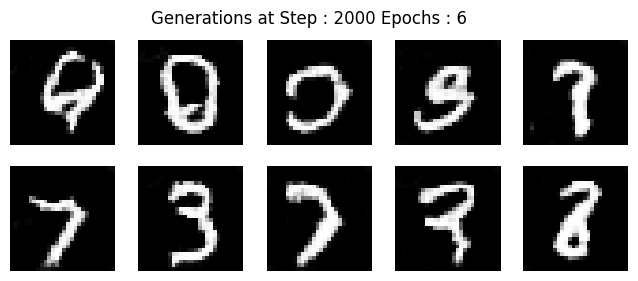

 40%|███▉      | 2999/7500 [00:30<00:52, 86.54it/s]

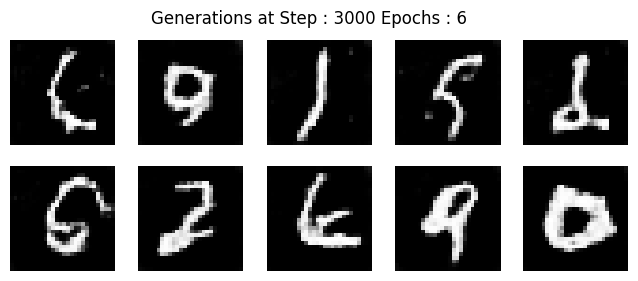

 53%|█████▎    | 3996/7500 [00:41<00:33, 104.11it/s]

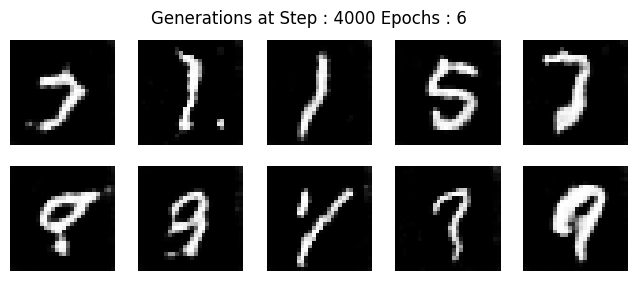

 67%|██████▋   | 4994/7500 [00:51<00:23, 105.70it/s]

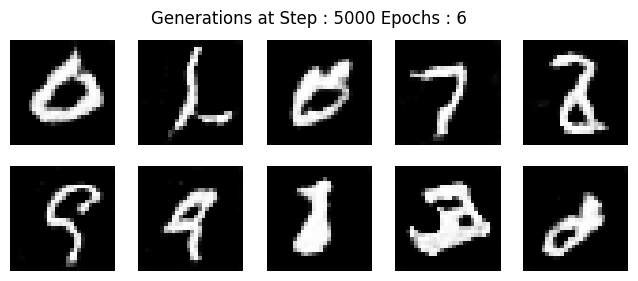

 80%|███████▉  | 5990/7500 [01:02<00:14, 107.09it/s]

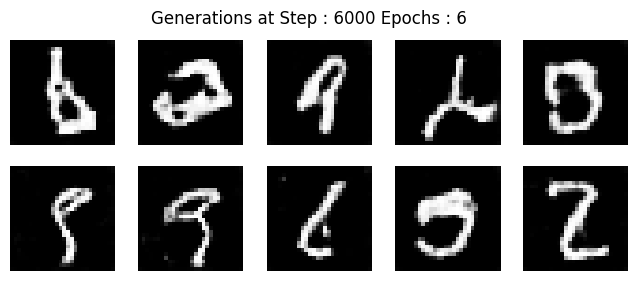

 93%|█████████▎| 6996/7500 [01:12<00:04, 105.76it/s]

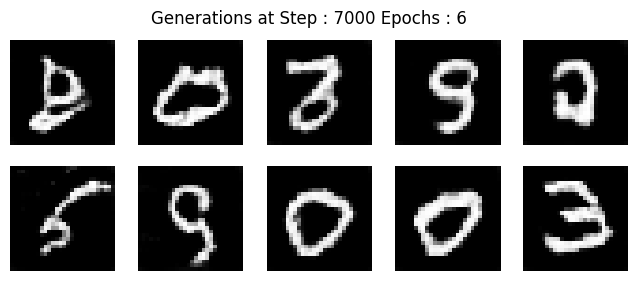

  0%|          | 0/7500 [00:00<?, ?it/s]

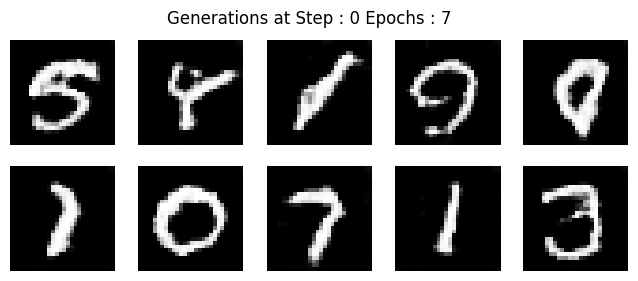

 13%|█▎        | 994/7500 [00:11<01:11, 91.60it/s]

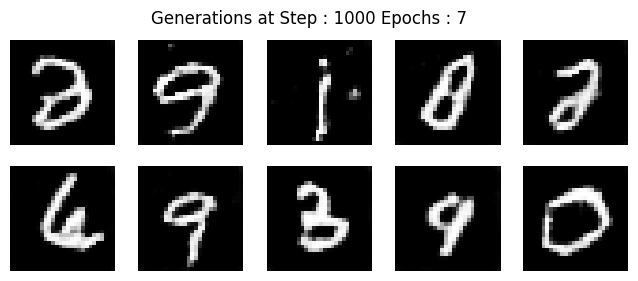

 27%|██▋       | 1992/7500 [00:21<00:52, 105.54it/s]

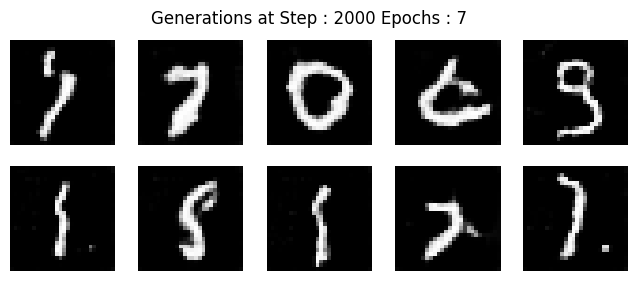

 40%|███▉      | 2999/7500 [00:32<00:42, 106.95it/s]

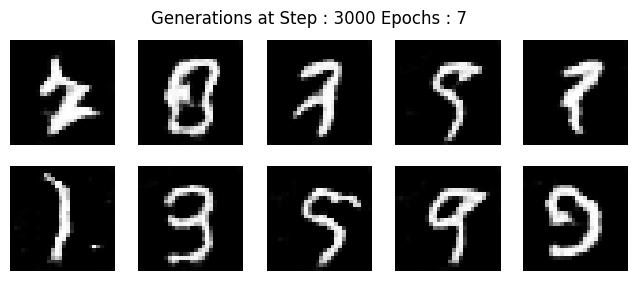

 53%|█████▎    | 3991/7500 [00:42<00:33, 103.89it/s]

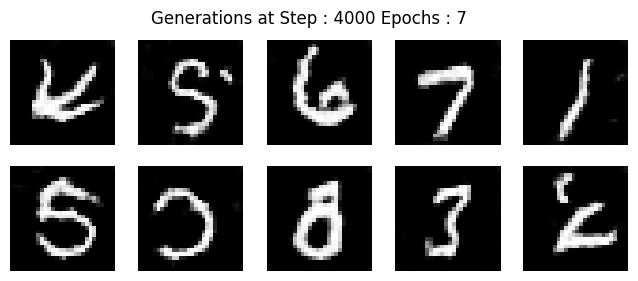

 67%|██████▋   | 4993/7500 [00:52<00:30, 81.11it/s]

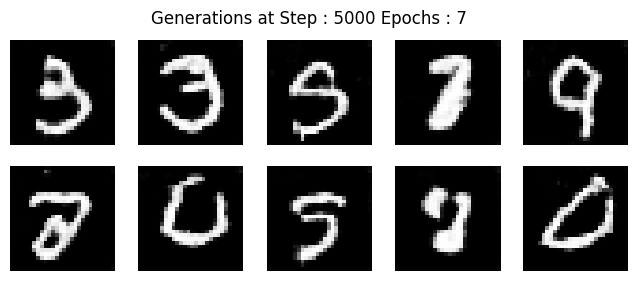

 80%|███████▉  | 5995/7500 [01:03<00:14, 100.88it/s]

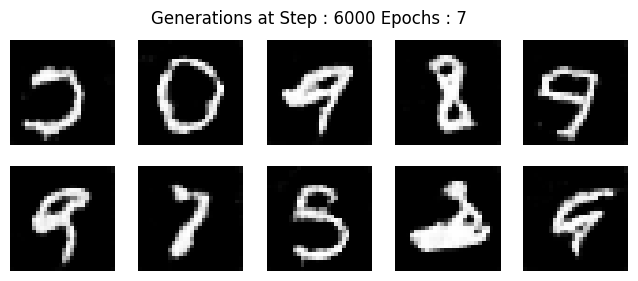

 93%|█████████▎| 6995/7500 [01:14<00:04, 102.89it/s]

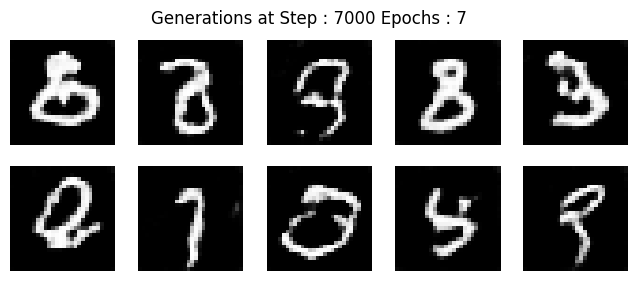

  0%|          | 0/7500 [00:00<?, ?it/s]

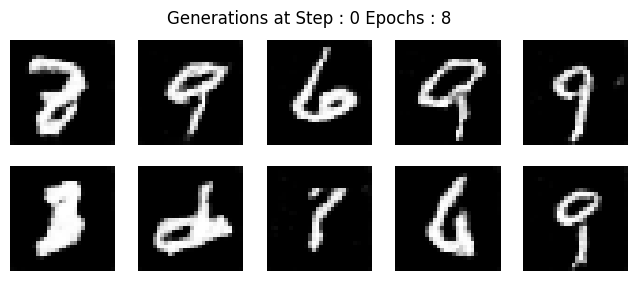

 13%|█▎        | 997/7500 [00:09<01:19, 82.02it/s]

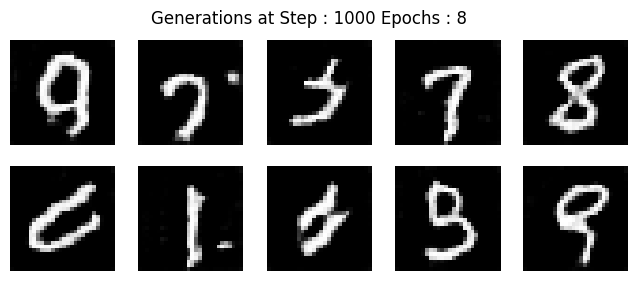

 27%|██▋       | 1994/7500 [00:20<00:51, 106.87it/s]

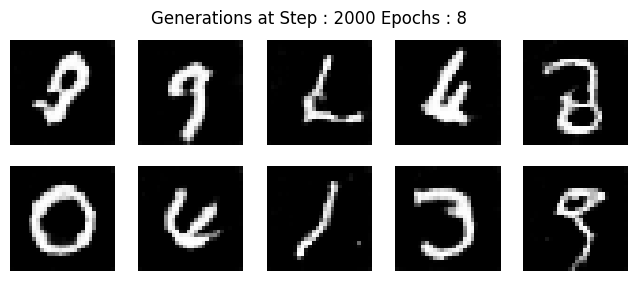

 40%|███▉      | 2994/7500 [00:30<00:41, 107.98it/s]

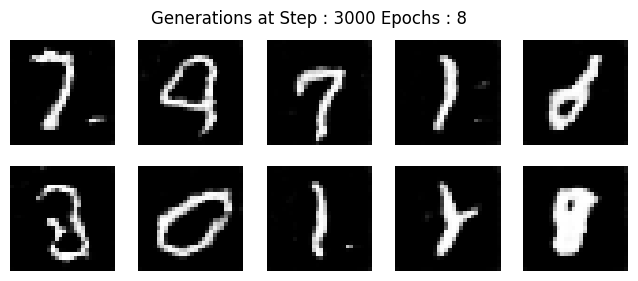

 53%|█████▎    | 3992/7500 [00:40<00:32, 108.09it/s]

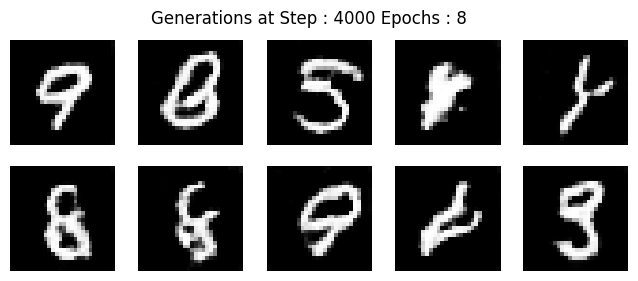

 67%|██████▋   | 4999/7500 [00:51<00:23, 105.71it/s]

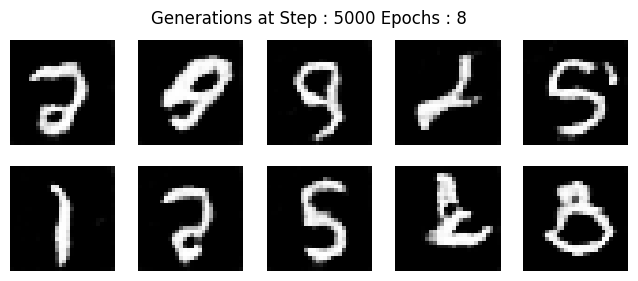

 80%|███████▉  | 5990/7500 [01:01<00:14, 106.35it/s]

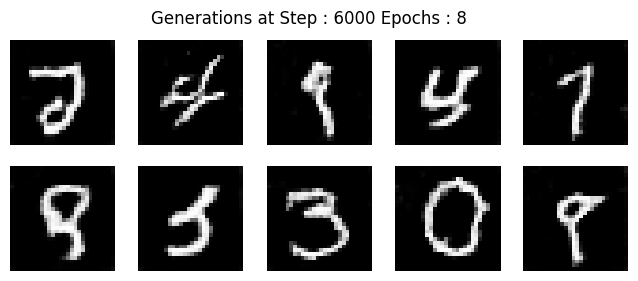

 93%|█████████▎| 6995/7500 [01:11<00:06, 82.65it/s]

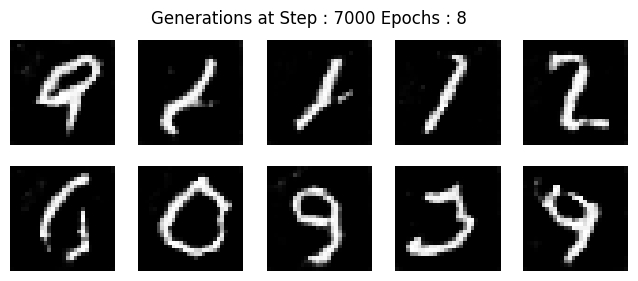

  0%|          | 0/7500 [00:00<?, ?it/s]

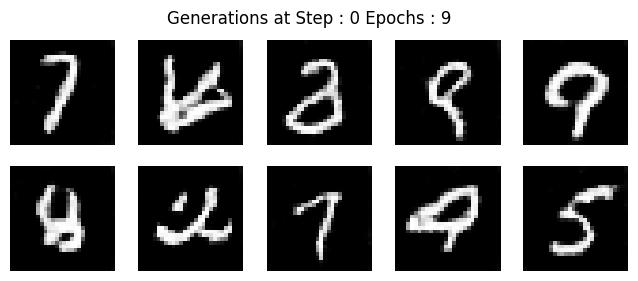

 13%|█▎        | 994/7500 [00:10<01:00, 106.95it/s]

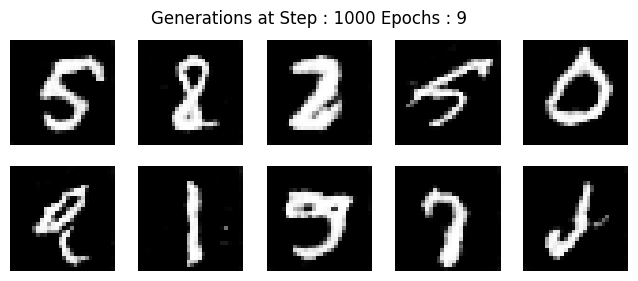

 27%|██▋       | 1993/7500 [00:20<01:08, 80.62it/s]

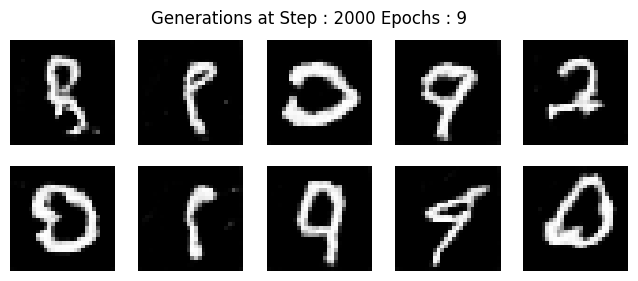

 40%|███▉      | 2998/7500 [00:30<00:42, 104.86it/s]

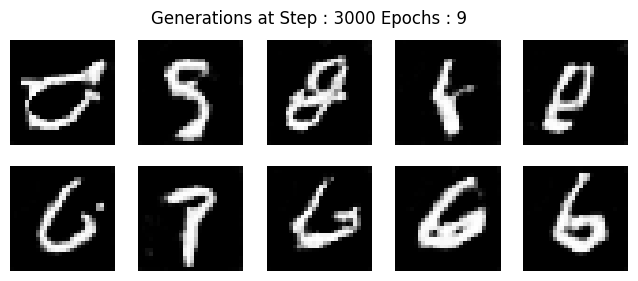

 53%|█████▎    | 4000/7500 [00:41<00:32, 106.95it/s]

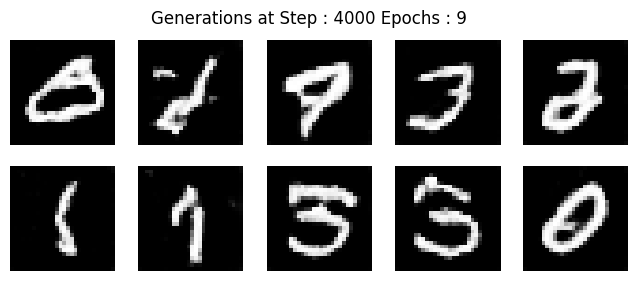

 67%|██████▋   | 4999/7500 [00:51<00:23, 106.30it/s]

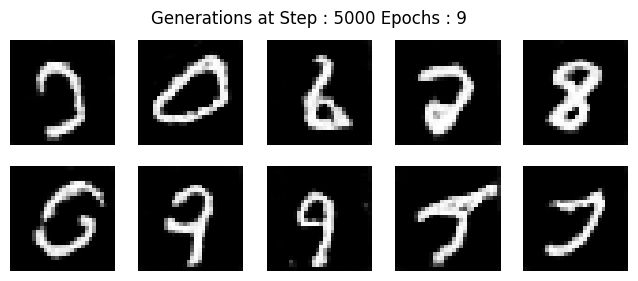

 80%|███████▉  | 5999/7500 [01:02<00:13, 107.38it/s]

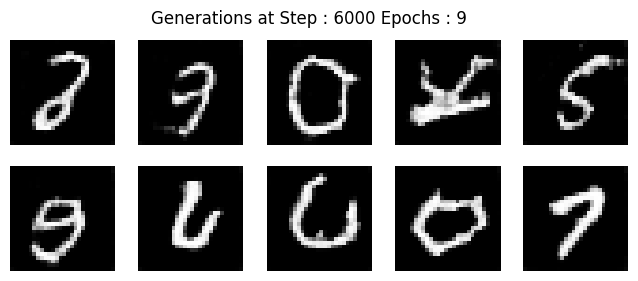

 93%|█████████▎| 6994/7500 [01:12<00:04, 103.31it/s]

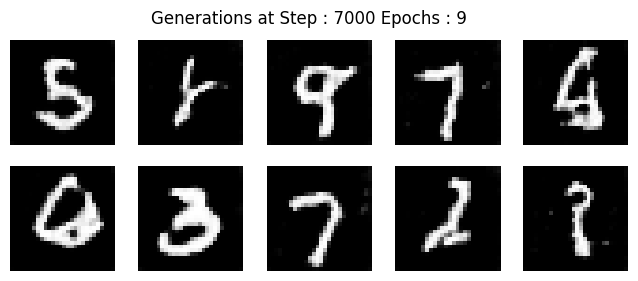

  0%|          | 0/7500 [00:00<?, ?it/s]

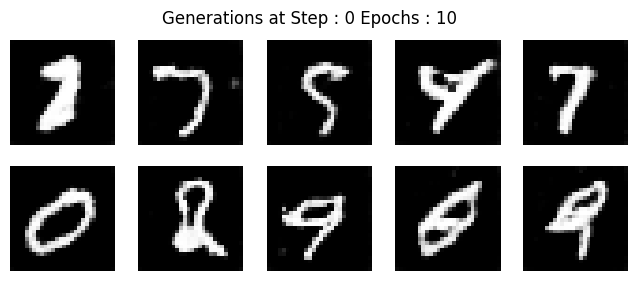

 13%|█▎        | 992/7500 [00:10<01:06, 97.90it/s]

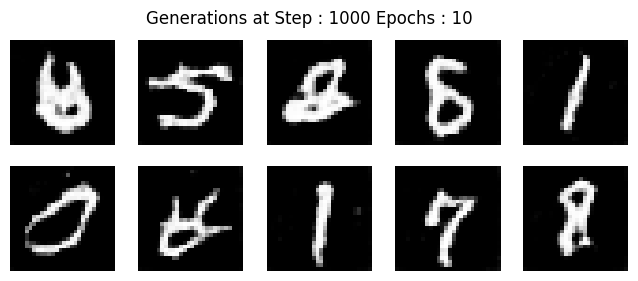

 27%|██▋       | 1994/7500 [00:21<00:51, 105.93it/s]

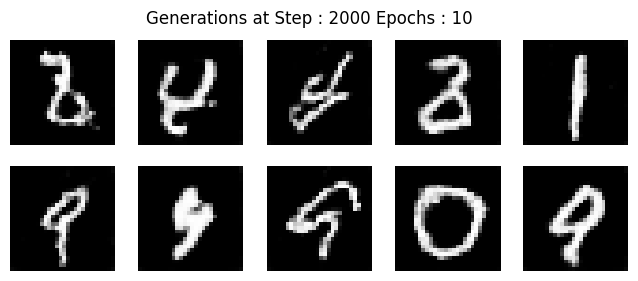

 40%|███▉      | 2994/7500 [00:32<00:54, 82.71it/s]

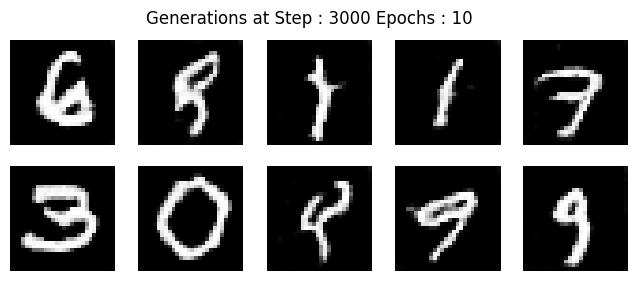

 53%|█████▎    | 3992/7500 [00:43<00:46, 75.69it/s]

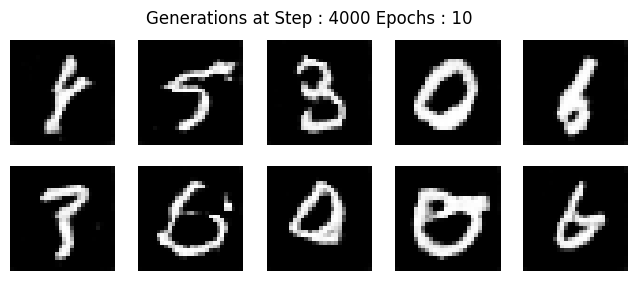

 67%|██████▋   | 4992/7500 [00:54<00:30, 81.02it/s]

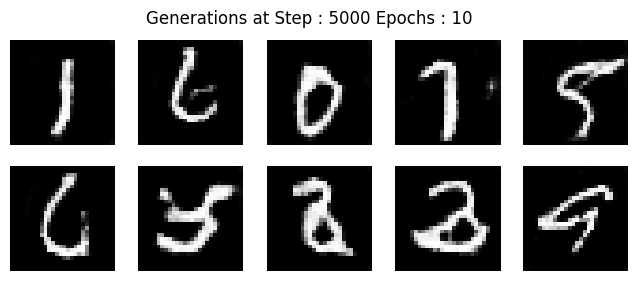

 80%|███████▉  | 5990/7500 [01:05<00:15, 100.14it/s]

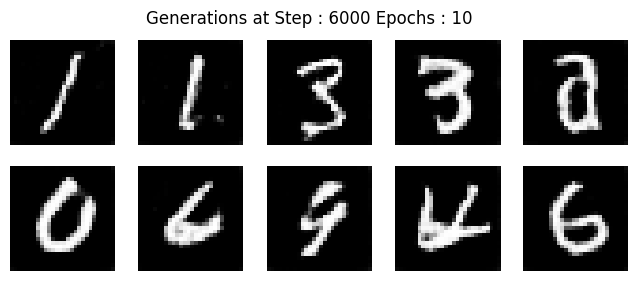

 93%|█████████▎| 6997/7500 [01:16<00:05, 99.12it/s]

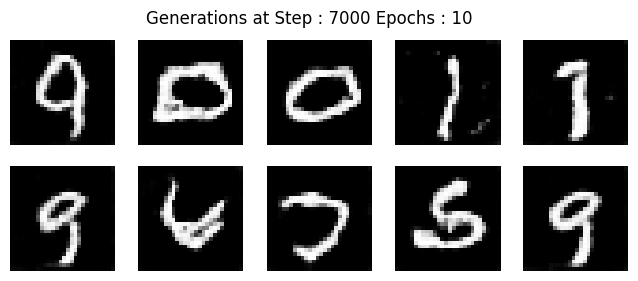

100%|██████████| 7500/7500 [01:22<00:00, 90.56it/s]


In [14]:
# Initializing some constants/variables
EPOCHS = 10
STEP_SIZE = 1000

# Starting the training loop
for epoch in range(EPOCHS):

    # Maintaining the loss per step
    step_size = 0

    for real, _ in tqdm(dataloader):

        # Collect to the current batch size.
        curr_batch_size = len(real)
        real = real.to(DEVICE)

        ## Training the Discriminator
        disc_opt.zero_grad()

        # Discriminator on the generated images.
        noise_samples = generate_noise(samples = curr_batch_size)
        synthetic_images = generator(noise_samples)
        disc_syn_preds = discriminator(synthetic_images.detach())

        # Discriminator on the real images.
        disc_real_preds = discriminator(real)

        # Average discriminator loss
        disc_syn_loss = criterion(disc_syn_preds, torch.zeros_like(disc_syn_preds))
        disc_real_loss = criterion(disc_real_preds, torch.ones_like(disc_real_preds))
        discriminator_loss = (disc_syn_loss + disc_real_loss) / 2

        discriminator_loss.backward(retain_graph=True)
        disc_opt.step()

        ## Training the Generator
        gen_opt.zero_grad()

        noise_samples = generate_noise(samples = curr_batch_size)
        synthetic_images = generator(noise_samples)
        disc_syn_preds = discriminator(synthetic_images)

        generator_loss = criterion(disc_syn_preds, torch.ones_like(disc_syn_preds))
        generator_loss.backward()
        gen_opt.step()

        # Visualized generations after certain step.
        if (step_size % STEP_SIZE == 0):
            noise_vector = generate_noise(10)
            generations = generator(noise_vector)
            show_generations(
                generations, 2, 5,
                figsize=(8, 3),
                title = f"Generations at Step : {step_size} Epochs : {epoch+1}",
                save_loc = f"./Images/training_gen_{step_size}_epoch_{epoch+1}.png"
            )

        # Increment the step size
        step_size += 1


Despite **system limitations and memory constraints**, training the **DCGAN for a short duration of 10 epochs** with a **high number of steps** has yielded **impressive results**.

The **generated images** surpass my **initial expectations**, showcasing a **level of performance beyond anticipation**. This clearly underscores the **potential of deep convolutional generative adversarial networks**. With **further training in the future**, the **model's performance** is expected to excel, indicating the **robust capabilities of this approach.**

# **Model Generations**

After the **meticulous training** of our model, let's take a moment to **appreciate the culmination of its efforts**. Join me as we delve into the **final generations** produced by the model, showcasing the **pinnacle of its performance**.

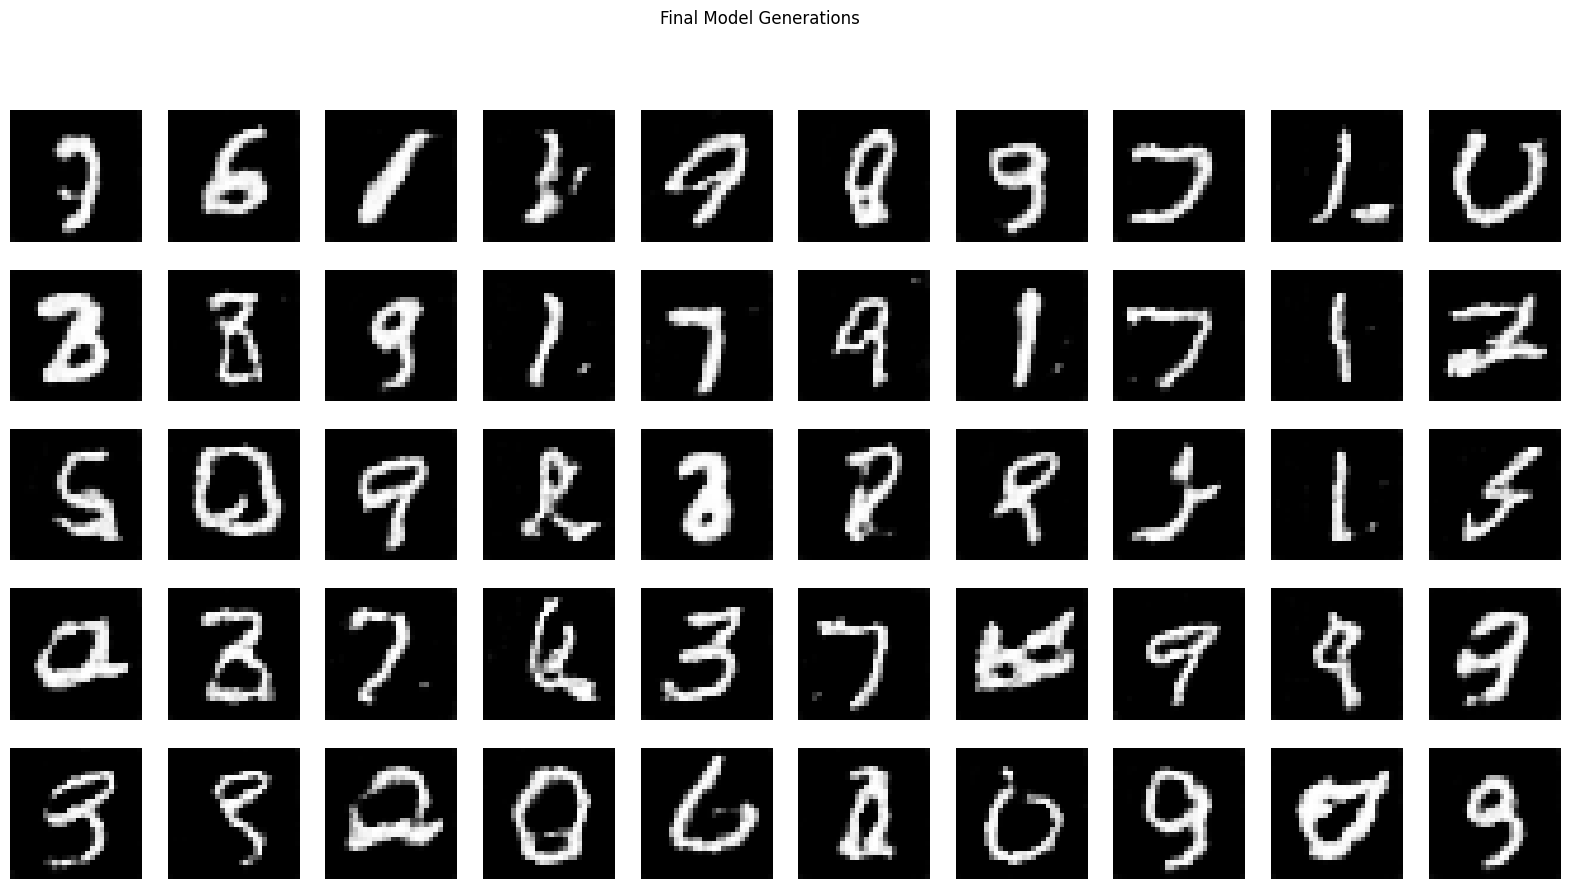

In [15]:
# Generate Images
noise = generate_noise(50)
syn_images = generator(noise)

# Show Generated Images
show_generations(
    syn_images, 5, 10,
    figsize=(20, 10),
    title="Final Model Generations",
    save_loc = "./FinalGenerations.png"
)

After a **careful inspection** of the **model's outputs post-training**, it's evident that the results are **quite commendable**. While **not every image attains perfection**, the **model demonstrates a noteworthy effort** in **generating realistic images**—an accomplishment aligned with our objectives. This underscores the **model's potential** for **growth and learning over time**, fostering the **creation of increasingly realistic images.**

At its **current stage**, the model exhibits a **perceptible understanding—opting** for **black pixels** in the **periphery and white pixels in the middle**, forming discernible **numerical patterns**. It has seemingly mastered the **art of generating varied digits**, showcasing prowess in rendering numbers like **3, 0, 1, 4, and even 9.**

# **Summary**

* 🚀 In this exhilarating exploration, we delved into the creation of a groundbreaking **Deep Convolutional Generative Adversarial Network (DCGAN)**, where the spotlight shines on the meticulously crafted **generator 🎨 and discriminator 🔍.**

* The **generator**, empowered by the wizardry of **convolutional layers**, wields the ability to metamorphose **random noise vectors into spellbinding, realistic images.** Meanwhile, **the discriminator**, a virtuoso classifier 🕵️‍♂️, deftly navigates the realm of distinguishing **genuine masterpieces from their synthetic counterparts.**

* Despite the constraints of a **brief training period 🕒**, the model unfurled its wings, revealing **exceptional prowess in image generation** that soared beyond our **initial celestial expectations 🌟**.

This brief yet **resonant expedition underscores** the **significant potential** residing within the realm of **deep convolutional generative adversarial networks 🤖**, where the alchemy of AI crafts **high-fidelity synthetic masterpieces.**

----

Thank you for joining me on this exploration of **Deep Convolutional Generative Adversarial Networks (DCGANs)**. Your engagement until the final page is truly appreciated. Wishing you a splendid day, and I look forward to our rendezvous in future notebooks.

Best regards,

**DeepNets** 🌟